Control Stores Selected:
Trial Store 77: Control Store 233
Trial Store 86: Control Store 155
Trial Store 88: Control Store 237


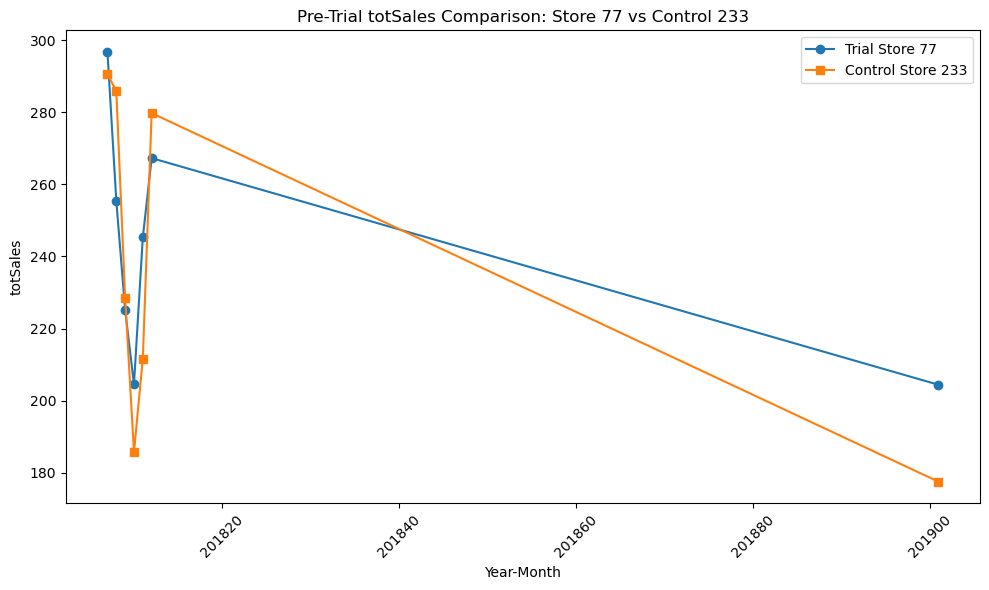

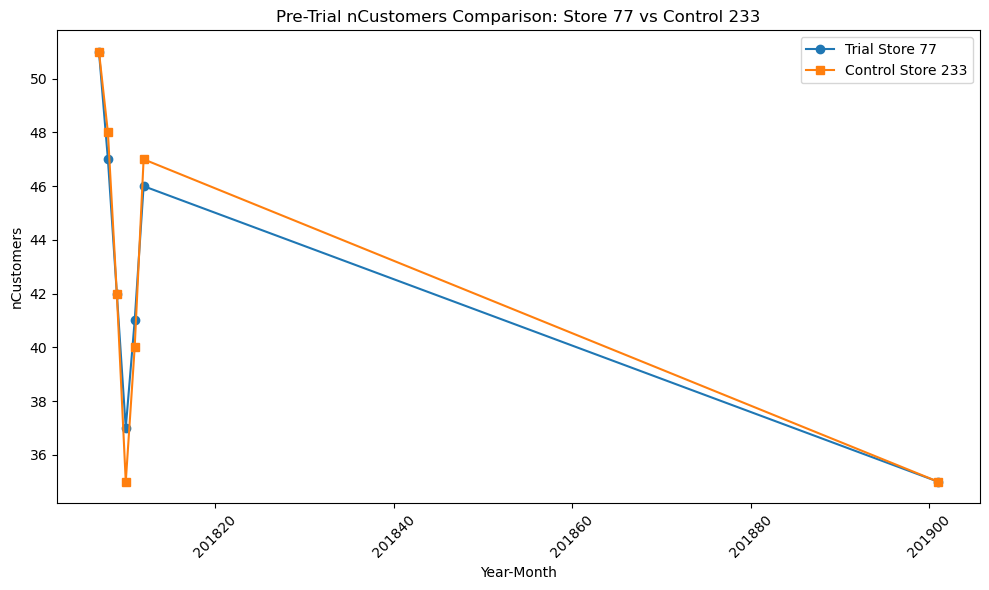

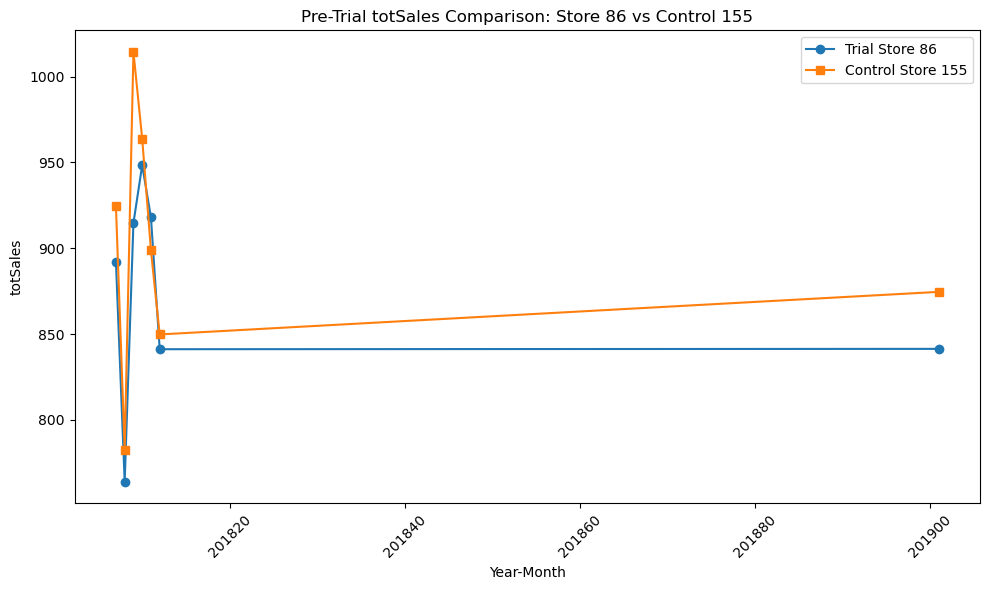

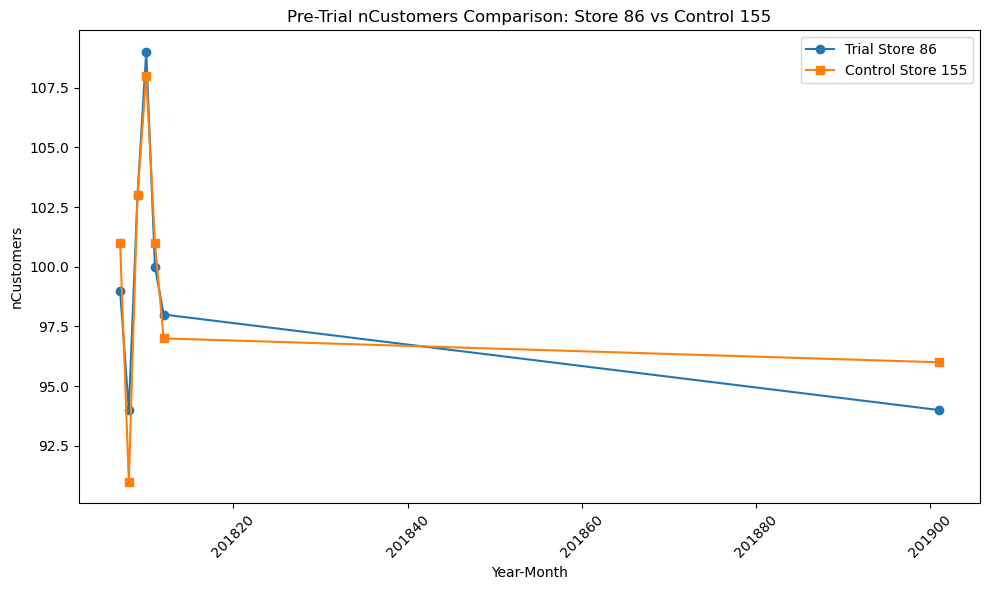

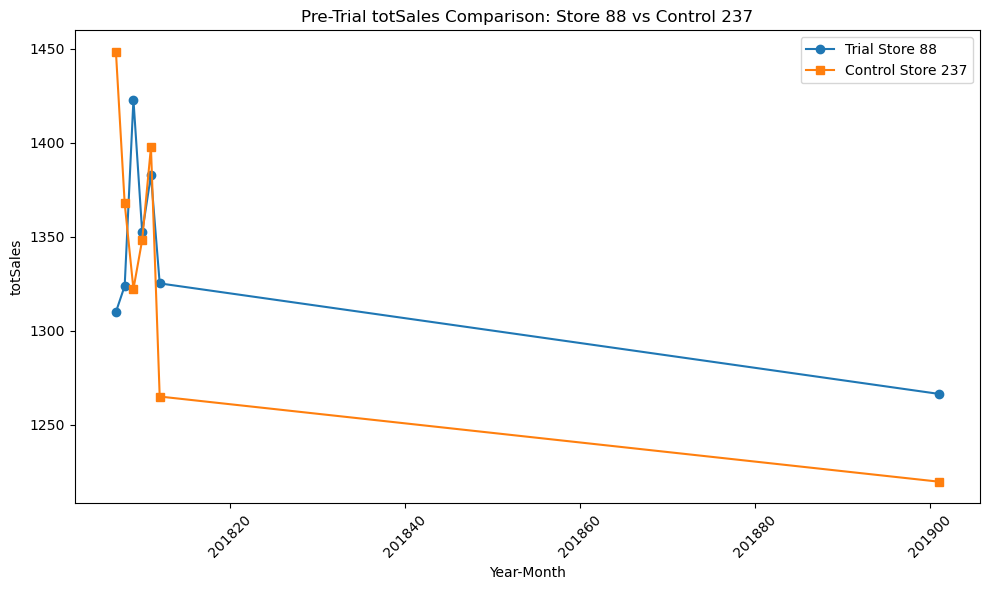

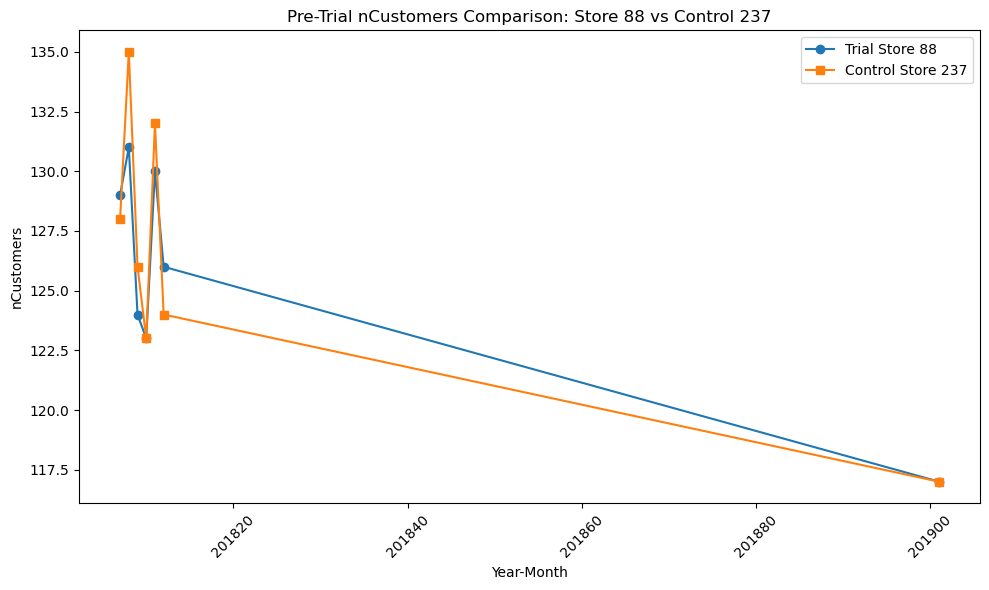


Analysis for Trial Store 77 (Control Store 233):


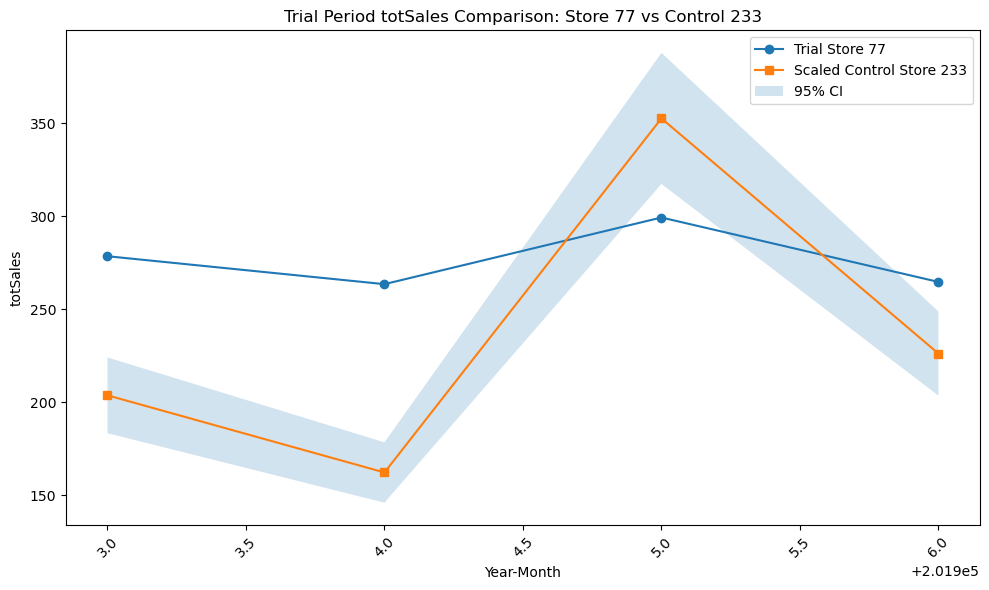

Sales t-values (critical value = 1.895):
   YEARMONTH     tValue
0     201903   7.339116
1     201904  12.476373
2     201905   3.023650
3     201906   3.406093


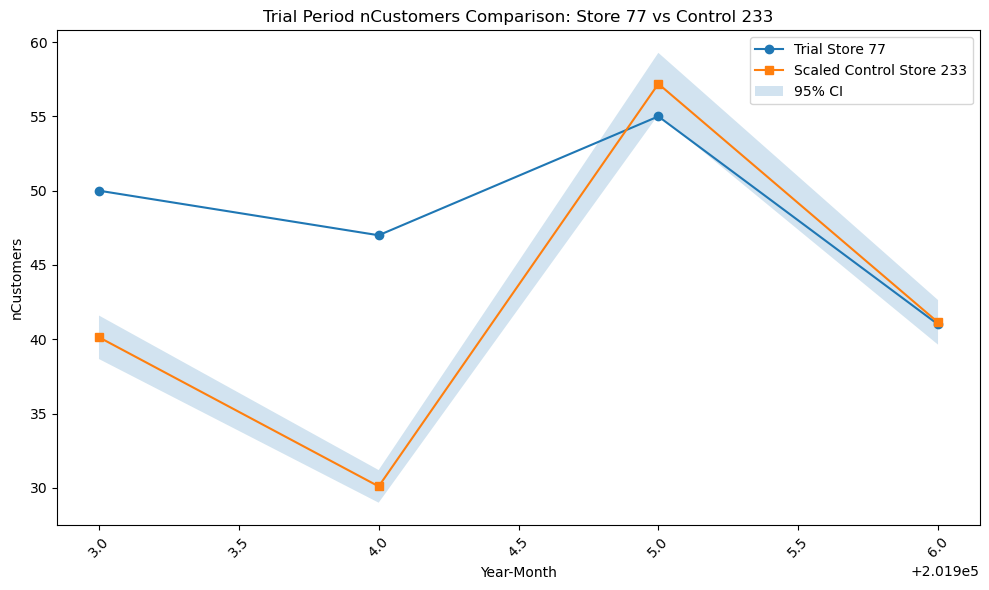

Customers t-values (critical value = 1.895):
   YEARMONTH     tValue
0     201903  13.476388
1     201904  30.778725
2     201905   2.100509
3     201906   0.183352

Analysis for Trial Store 86 (Control Store 155):


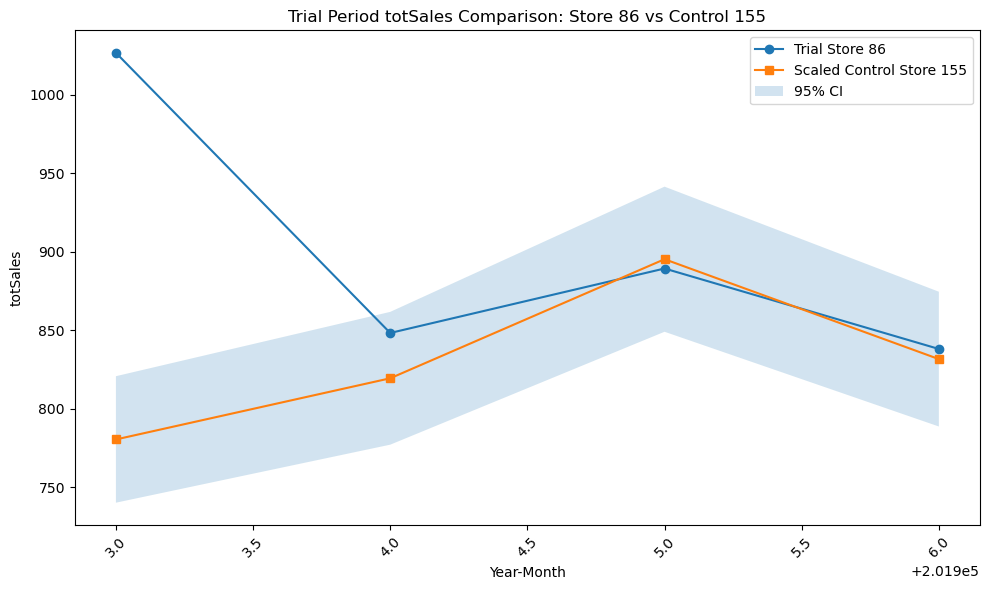

Sales t-values (critical value = 1.895):
   YEARMONTH     tValue
0     201903  12.226922
1     201904   1.364580
2     201905   0.256176
3     201906   0.300725


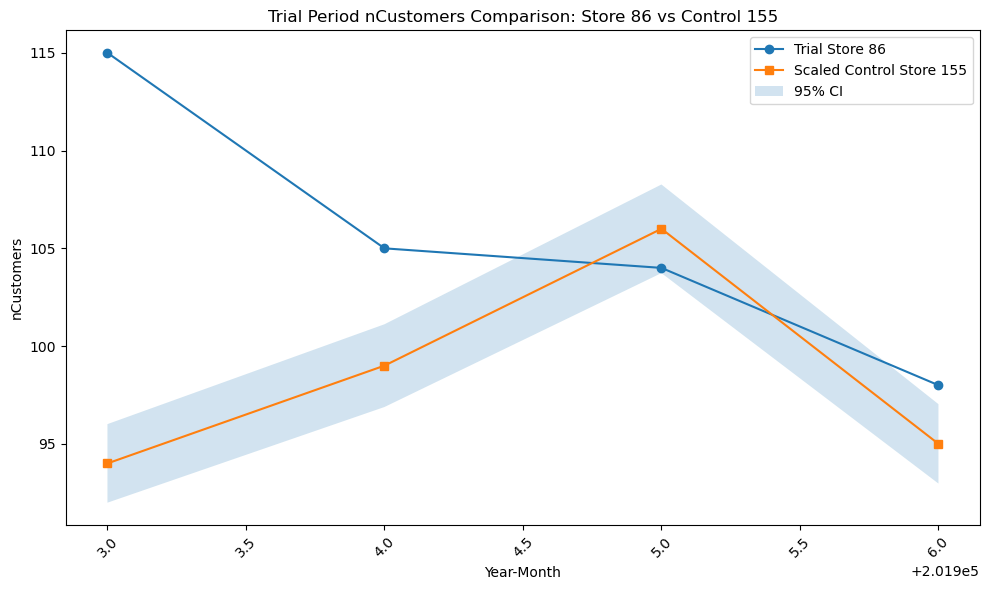

Customers t-values (critical value = 1.895):
   YEARMONTH     tValue
0     201903  20.903430
1     201904   5.670772
2     201905   1.765429
3     201906   2.954771

Analysis for Trial Store 88 (Control Store 237):


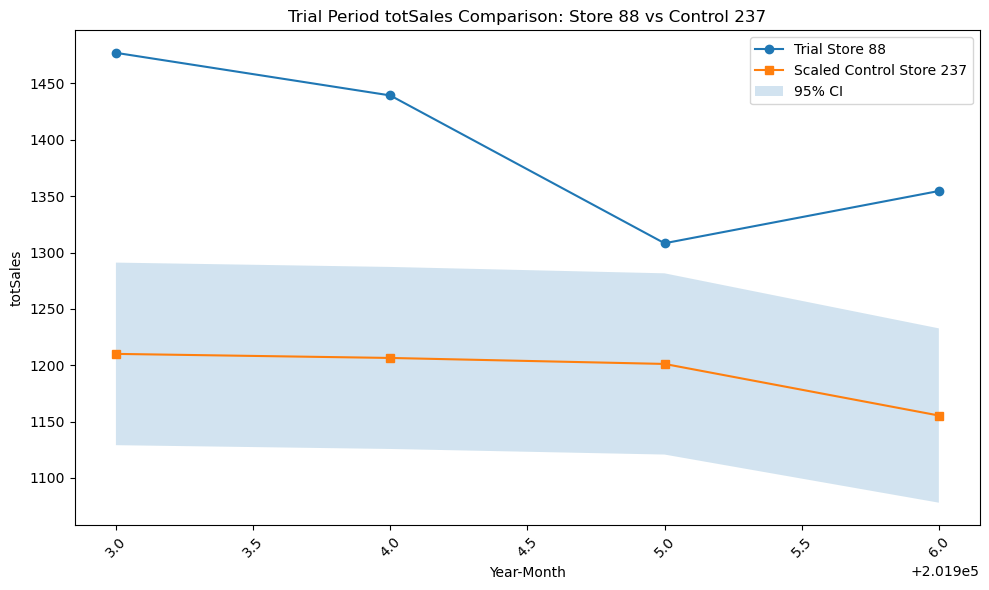

Sales t-values (critical value = 1.895):
   YEARMONTH    tValue
0     201903  6.595668
1     201904  5.768527
2     201905  2.663672
3     201906  5.151513


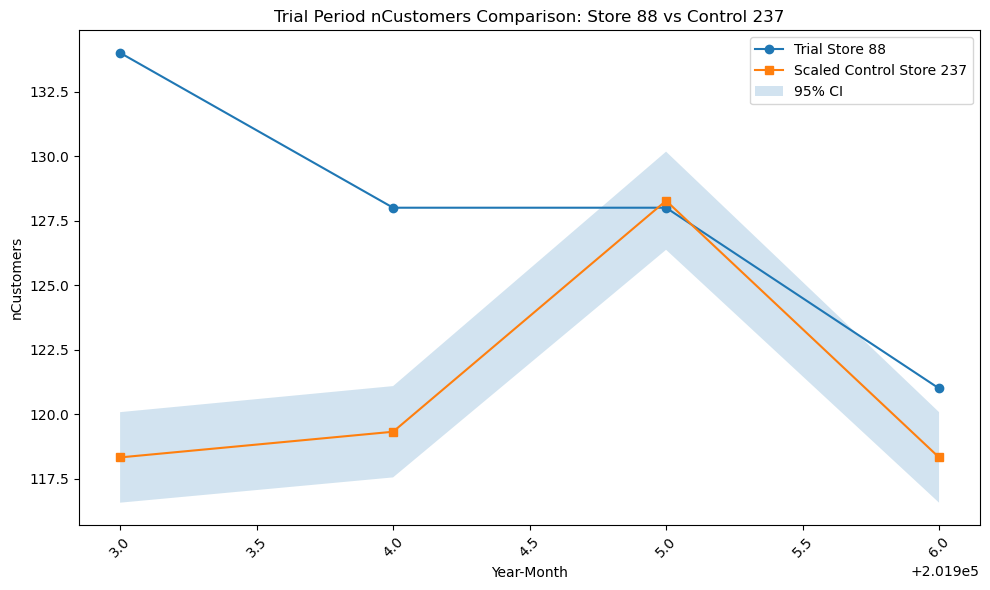

Customers t-values (critical value = 1.895):
   YEARMONTH     tValue
0     201903  17.873693
1     201904   9.814423
2     201905   0.285303
3     201906   3.047677

Summary of Findings:

Trial Store 77 (Control Store 233):
- Sales: Significant increase in 4 of 4 trial months.
- Customers: Significant increase in 3 of 4 trial months.
Conclusion: Trial likely successful.

Trial Store 86 (Control Store 155):
- Sales: Significant increase in 1 of 4 trial months.
- Customers: Significant increase in 3 of 4 trial months.
Conclusion: Trial likely successful.

Trial Store 88 (Control Store 237):
- Sales: Significant increase in 4 of 4 trial months.
- Customers: Significant increase in 3 of 4 trial months.
Conclusion: Trial likely successful.


In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, t
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# S


# Step 1: Load and Preprocess Data
# Reading the CSV data
data = pd.read_csv('QVI_data.csv')

# Convert DATE to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Create YEARMONTH column
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Filter out PROD_QTY == 200 (outlier as per previous context)
data = data[data['PROD_QTY'] != 200]

# Step 2: Calculate Monthly Metrics
# Define pre-trial period (before February 2019, i.e., YEARMONTH < 201902)
pre_trial_period = data[data['YEARMONTH'] < 201902]

# Calculate metrics for each store and month
metrics = pre_trial_period.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxn=('TXN_ID', 'nunique'),
    nChips=('PROD_QTY', 'sum')
).reset_index()

# Calculate derived metrics
metrics['nTxnPerCust'] = metrics['nTxn'] / metrics['nCustomers']
metrics['nChipsPerTxn'] = metrics['nChips'] / metrics['nTxn']
metrics['avgPricePerUnit'] = metrics['totSales'] / metrics['nChips']

# Filter stores with data for all 7 months in pre-trial period (July 2018 - January 2019)
month_counts = metrics.groupby('STORE_NBR')['YEARMONTH'].nunique()
full_data_stores = month_counts[month_counts == 7].index
metrics = metrics[metrics['STORE_NBR'].isin(full_data_stores)]

# Step 3: Select Control Stores
def calculate_similarity(trial_store, metric, metrics_df):
    """
    Calculate correlation and magnitude distance for a trial store against all others.
    Returns a DataFrame with combined similarity scores.
    """
    trial_data = metrics_df[metrics_df['STORE_NBR'] == trial_store][['YEARMONTH', metric]].set_index('YEARMONTH')
    other_stores = metrics_df[metrics_df['STORE_NBR'] != trial_store]['STORE_NBR'].unique()
    
    scores = []
    
    for store in other_stores:
        store_data = metrics_df[metrics_df['STORE_NBR'] == store][['YEARMONTH', metric]].set_index('YEARMONTH')
        # Ensure both have same months
        common_months = trial_data.index.intersection(store_data.index)
        if len(common_months) < 7:
            continue
        
        trial_values = trial_data.loc[common_months, metric]
        store_values = store_data.loc[common_months, metric]
        
        # Correlation
        if trial_values.std() > 0 and store_values.std() > 0:
            corr, _ = pearsonr(trial_values, store_values)
        else:
            corr = 0
        
        # Magnitude distance
        magnitude_diff = abs(trial_values - store_values)
        max_magnitude = max(trial_values.max(), store_values.max())
        min_magnitude = min(trial_values.min(), store_values.min())
        if max_magnitude == min_magnitude:
            magnitude_dist = 0
        else:
            magnitude_dist = 1 - (magnitude_diff / (max_magnitude - min_magnitude)).mean()
        
        # Combine scores
        score = 0.5 * corr + 0.5 * magnitude_dist
        scores.append({'Control_Store': store, 'Score': score})
    
    return pd.DataFrame(scores)

# Trial stores
trial_stores = [77, 86, 88]

# Dictionary to store control stores
control_stores = {}

for store in trial_stores:
    # Calculate scores for totSales and nCustomers
    sales_scores = calculate_similarity(store, 'totSales', metrics)
    cust_scores = calculate_similarity(store, 'nCustomers', metrics)
    
    # Merge scores
    combined_scores = sales_scores.merge(cust_scores, on='Control_Store', suffixes=('_sales', '_cust'))
    combined_scores['finalControlscore'] = (combined_scores['Score_sales'] + combined_scores['Score_cust']) / 2
    
    # Select control store with highest score
    control_store = combined_scores.loc[combined_scores['finalControlscore'].idxmax(), 'Control_Store']
    control_stores[store] = control_store

print("Control Stores Selected:")
for trial, control in control_stores.items():
    print(f"Trial Store {trial}: Control Store {control}")

# Step 4: Visualize Pre-Trial Similarity
def plot_pre_trial_comparison(trial_store, control_store, metric, metrics_df):
    """
    Plot pre-trial trends for trial and control stores.
    """
    trial_data = metrics_df[metrics_df['STORE_NBR'] == trial_store][['YEARMONTH', metric]]
    control_data = metrics_df[metrics_df['STORE_NBR'] == control_store][['YEARMONTH', metric]]
    
    plt.figure(figsize=(10, 6))
    plt.plot(trial_data['YEARMONTH'], trial_data[metric], label=f'Trial Store {trial_store}', marker='o')
    plt.plot(control_data['YEARMONTH'], control_data[metric], label=f'Control Store {control_store}', marker='s')
    plt.title(f'Pre-Trial {metric} Comparison: Store {trial_store} vs Control {control_store}')
    plt.xlabel('Year-Month')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for each trial store
for trial_store, control_store in control_stores.items():
    plot_pre_trial_comparison(trial_store, control_store, 'totSales', metrics)
    plot_pre_trial_comparison(trial_store, control_store, 'nCustomers', metrics)

# Step 5: Assess Trial Impact
# Trial period: March 2019 to June 2019 (201903 to 201906)
trial_period = data[(data['YEARMONTH'] >= 201903) & (data['YEARMONTH'] <= 201906)]

# Calculate trial period metrics
trial_metrics = trial_period.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique')
).reset_index()

def assess_trial_impact(trial_store, control_store, metric, pre_trial_metrics, trial_metrics):
    """
    Assess trial impact with scaling, percentage difference, and statistical significance.
    Returns t-values and plots.
    """
    # Pre-trial data
    trial_pre = pre_trial_metrics[pre_trial_metrics['STORE_NBR'] == trial_store][['YEARMONTH', metric]]
    control_pre = pre_trial_metrics[pre_trial_metrics['STORE_NBR'] == control_store][['YEARMONTH', metric]]
    
    # Calculate scaling factor
    trial_avg = trial_pre[metric].mean()
    control_avg = control_pre[metric].mean()
    scaling_factor = trial_avg / control_avg if control_avg != 0 else 1
    
    # Trial period data
    trial_trial = trial_metrics[trial_metrics['STORE_NBR'] == trial_store][['YEARMONTH', metric]]
    control_trial = trial_metrics[trial_metrics['STORE_NBR'] == control_store][['YEARMONTH', metric]]
    
    # Scale control data
    control_trial['scaled_' + metric] = control_trial[metric] * scaling_factor
    
    # Merge trial and control data
    comparison = trial_trial.merge(control_trial, on='YEARMONTH', suffixes=('_trial', '_control'))
    
    # Calculate percentage difference
    comparison['percentageDiff'] = abs(comparison[metric + '_trial'] - comparison['scaled_' + metric]) / comparison['scaled_' + metric]
    
    # Calculate pre-trial standard deviation
    pre_trial_comparison = trial_pre.merge(control_pre, on='YEARMONTH', suffixes=('_trial', '_control'))
    pre_trial_comparison['percentageDiff'] = abs(pre_trial_comparison[metric + '_trial'] - pre_trial_comparison[metric + '_control'] * scaling_factor) / (pre_trial_comparison[metric + '_control'] * scaling_factor)
    std_dev = pre_trial_comparison['percentageDiff'].std()
    
    # Calculate t-values
    comparison['tValue'] = comparison['percentageDiff'] / std_dev
    
    # Plot trial period with confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(comparison['YEARMONTH'], comparison[metric + '_trial'], label=f'Trial Store {trial_store}', marker='o')
    plt.plot(comparison['YEARMONTH'], comparison['scaled_' + metric], label=f'Scaled Control Store {control_store}', marker='s')
    
    # Confidence intervals (5th and 95th percentiles)
    ci_lower = comparison['scaled_' + metric] - 2 * std_dev * comparison['scaled_' + metric]
    ci_upper = comparison['scaled_' + metric] + 2 * std_dev * comparison['scaled_' + metric]
    plt.fill_between(comparison['YEARMONTH'], ci_lower, ci_upper, alpha=0.2, label='95% CI')
    
    plt.title(f'Trial Period {metric} Comparison: Store {trial_store} vs Control {control_store}')
    plt.xlabel('Year-Month')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Return t-values
    return comparison[['YEARMONTH', 'tValue']]

# Step 6: Run Analysis and Output Results
results = {}
t_critical = t.ppf(0.95, df=7)  # 95th percentile for 7 degrees of freedom

for trial_store, control_store in control_stores.items():
    print(f"\nAnalysis for Trial Store {trial_store} (Control Store {control_store}):")
    
    # Assess sales
    sales_tvalues = assess_trial_impact(trial_store, control_store, 'totSales', metrics, trial_metrics)
    print(f"Sales t-values (critical value = {t_critical:.3f}):")
    print(sales_tvalues)
    
    # Assess customers
    cust_tvalues = assess_trial_impact(trial_store, control_store, 'nCustomers', metrics, trial_metrics)
    print(f"Customers t-values (critical value = {t_critical:.3f}):")
    print(cust_tvalues)
    
    # Store results
    results[trial_store] = {
        'control_store': control_store,
        'sales_tvalues': sales_tvalues,
        'cust_tvalues': cust_tvalues
    }

# Step 7: Summarize Results
print("\nSummary of Findings:")
for trial_store in trial_stores:
    sales_significant = (results[trial_store]['sales_tvalues']['tValue'] > t_critical).sum()
    cust_significant = (results[trial_store]['cust_tvalues']['tValue'] > t_critical).sum()
    print(f"\nTrial Store {trial_store} (Control Store {results[trial_store]['control_store']}):")
    print(f"- Sales: Significant increase in {sales_significant} of 4 trial months.")
    print(f"- Customers: Significant increase in {cust_significant} of 4 trial months.")
    print(f"Conclusion: {'Trial likely successful' if sales_significant >= 2 or cust_significant >= 2 else 'Mixed or no significant impact'}.")
